In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Görsellerin notebook içinde görünmesini sağlar
%matplotlib inline

# Veriyi yükle
df = pd.read_csv('credit_risk_dataset.csv')

# İlk 5 satır ve genel bilgi
print(df.info())
print("\nEksik Değer Sayısı:\n", df.isnull().sum())
print("\nİstatistiksel Özet:\n", df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB
None

Eksik Değer Sayısı:
 pers

In [2]:
# 1. Yaş ve Çalışma Süresi Outlier Analizi
print("Yaşı 80'den büyük olanlar:", df[df['person_age'] > 80].shape[0])
print("Çalışma süresi yaştan büyük olan saçma veriler:", df[df['person_emp_length'] > df['person_age']].shape[0])

# Temizlik Operasyonu
# Yaşı 100'den küçük olanları tutalım
df = df[df['person_age'] < 100]

# Çalışma süresi yaşından fazla olanları (mantık hatası) temizleyelim
df = df[df['person_emp_length'] < 60] # 60 yıl bile çok ama 123'ten iyidir

# Kontrol
print("\nYeni Max Yaş:", df['person_age'].max())
print("Yeni Max Çalışma Süresi:", df['person_emp_length'].max())

Yaşı 80'den büyük olanlar: 7
Çalışma süresi yaştan büyük olan saçma veriler: 2

Yeni Max Yaş: 94
Yeni Max Çalışma Süresi: 41.0


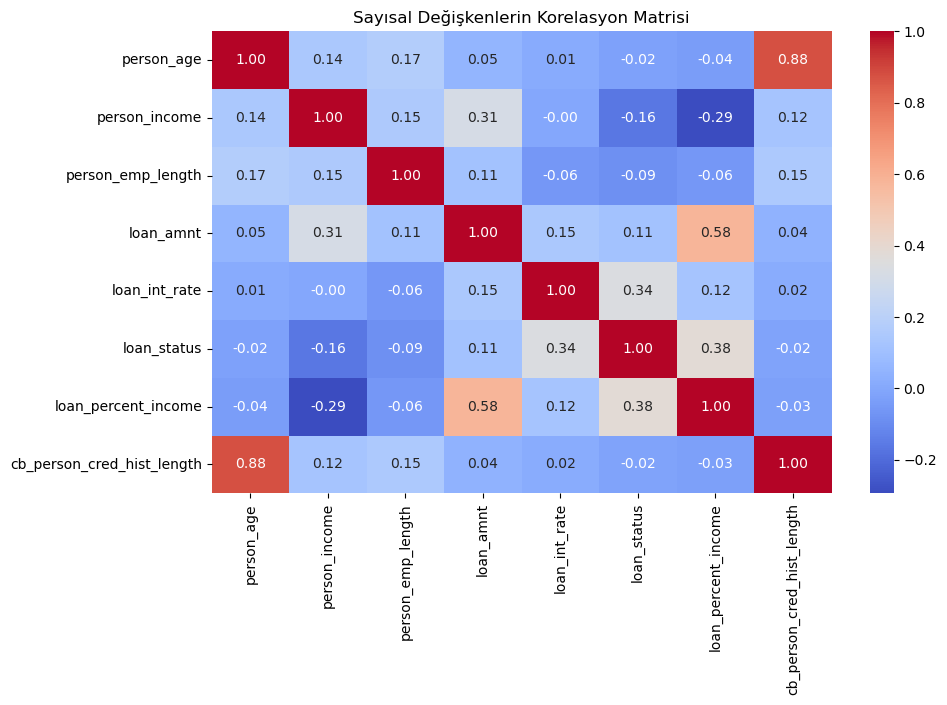

In [3]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Sayısal Değişkenlerin Korelasyon Matrisi")
plt.show()

In [4]:
# 1. Çalışma süresini genel medyan ile doldur (Basit yaklaşım)
df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].median())

# 2. Faiz oranını 'loan_grade' bazlı grup ortalamasıyla doldur (Profesyonel yaklaşım)
# Önce her grade'in ortalama faizini görelim
print("Grade bazlı faiz ortalamaları:\n", df.groupby('loan_grade')['loan_int_rate'].mean())

# Boşlukları doldur
df['loan_int_rate'] = df['loan_int_rate'].fillna(
    df.groupby('loan_grade')['loan_int_rate'].transform('mean')
)

# Kontrol: Boş veri kaldı mı?
print("\nYeni Eksik Veri Durumu:\n", df.isnull().sum())

Grade bazlı faiz ortalamaları:
 loan_grade
A     7.347180
B    11.002459
C    13.453147
D    15.348694
E    17.005655
F    18.597321
G    20.251525
Name: loan_int_rate, dtype: float64

Yeni Eksik Veri Durumu:
 person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


------------------------------
TERMINAL ANALİZİ: loan_status İLE İLİŞKİLER
------------------------------
loan_status                   1.000000
loan_percent_income           0.379823
loan_int_rate                 0.337939
loan_amnt                     0.112188
cb_person_cred_hist_length   -0.016830
person_age                   -0.022130
person_emp_length            -0.085966
person_income                -0.164128
Name: loan_status, dtype: float64
------------------------------


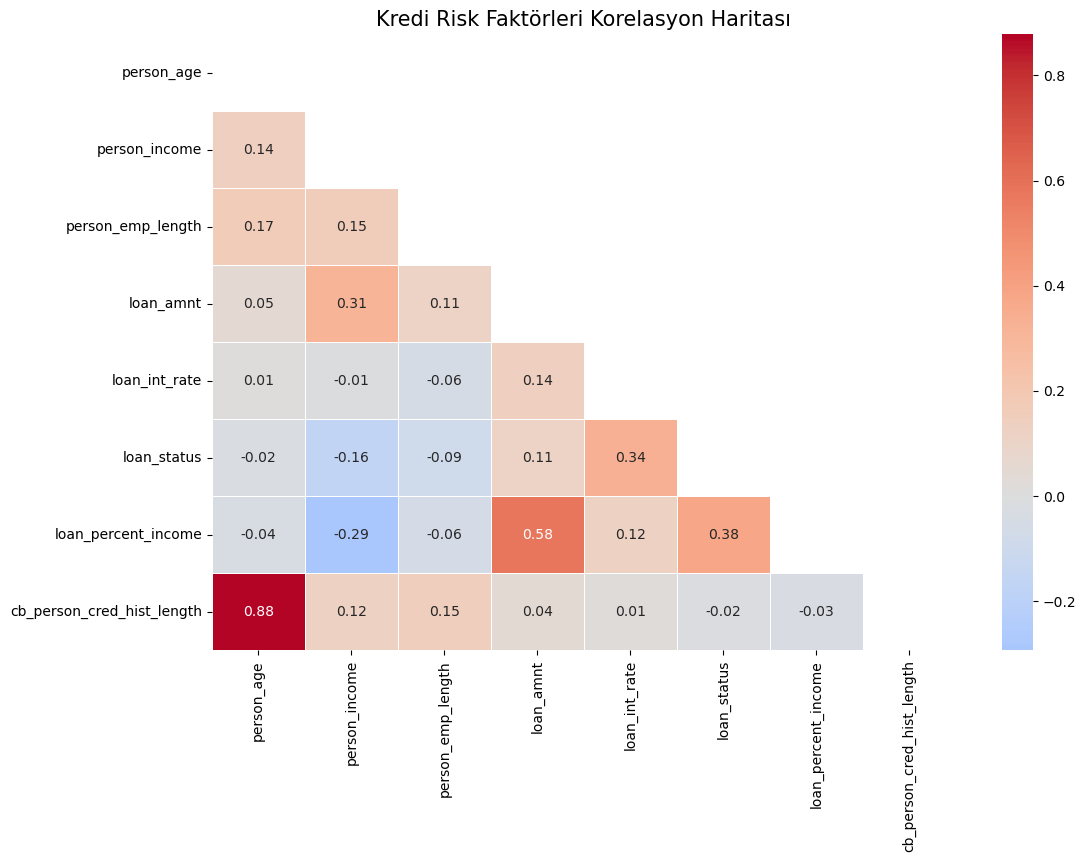

In [5]:
# 1. Sadece sayısal sütunları seçelim (Kategorik veriler korelasyona giremez)
numeric_df = df.select_dtypes(include=[np.number])

# 2. Korelasyon Matrisini Hesapla
corr_matrix = numeric_df.corr()

# --- TERMINAL ÇIKTISI ---
print("-" * 30)
print("TERMINAL ANALİZİ: loan_status İLE İLİŞKİLER")
print("-" * 30)
# loan_status ile olan korelasyonu büyükten küçüğe sıralıyoruz
correlations = corr_matrix['loan_status'].sort_values(ascending=False)
print(correlations)
print("-" * 30)

# --- GÖRSEL ÇIKTI (HEATMAP) ---
plt.figure(figsize=(12, 8))

# Alt üçgeni daha net görmek için üst kısmı maskeleyelim (Opsiyonel ama profesyonel gösterir)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True,          # Hücrelerin içine değerleri yaz
            fmt=".2f",           # Virgülden sonra 2 basamak
            cmap='coolwarm',     # Kırmızı (pozitif) - Mavi (negatif) dengesi
            center=0,            # 0 noktasını beyaz yap
            linewidths=.5)

plt.title("Kredi Risk Faktörleri Korelasyon Haritası", fontsize=15)
plt.show()

In [6]:
# 1. Kategorik Sütunların Dağılımı
categorical_cols = df.select_dtypes(include=['object']).columns
print("--- KATEGORİK SÜTUN ANALİZİ ---")
for col in categorical_cols:
    print(f"\n{col} Sütunu Benzersiz Değerleri ve Sayıları:")
    print(df[col].value_counts())

# 2. Sayısal Sütunların Dağılımı (Skewness - Çarpıklık)
print("\n" + "-"*30)
print("--- SAYISAL SÜTUN ÇARPIKLIK (SKEWNESS) ---")
# 0'dan ne kadar uzaksa o kadar dengesiz dağılmıştır
print(df.select_dtypes(include=[np.number]).skew())

--- KATEGORİK SÜTUN ANALİZİ ---

person_home_ownership Sütunu Benzersiz Değerleri ve Sayıları:
person_home_ownership
RENT        16072
MORTGAGE    13090
OWN          2410
OTHER         107
Name: count, dtype: int64

loan_intent Sütunu Benzersiz Değerleri ve Sayıları:
loan_intent
EDUCATION            6288
MEDICAL              5897
VENTURE              5553
PERSONAL             5367
DEBTCONSOLIDATION    5064
HOMEIMPROVEMENT      3510
Name: count, dtype: int64

loan_grade Sütunu Benzersiz Değerleri ve Sayıları:
loan_grade
A    10370
B    10183
C     6319
D     3555
E      952
F      236
G       64
Name: count, dtype: int64

cb_person_default_on_file Sütunu Benzersiz Değerleri ve Sayıları:
cb_person_default_on_file
N    26051
Y     5628
Name: count, dtype: int64

------------------------------
--- SAYISAL SÜTUN ÇARPIKLIK (SKEWNESS) ---
person_age                    1.948644
person_income                 9.815297
person_emp_length             1.247889
loan_amnt                     1.181859


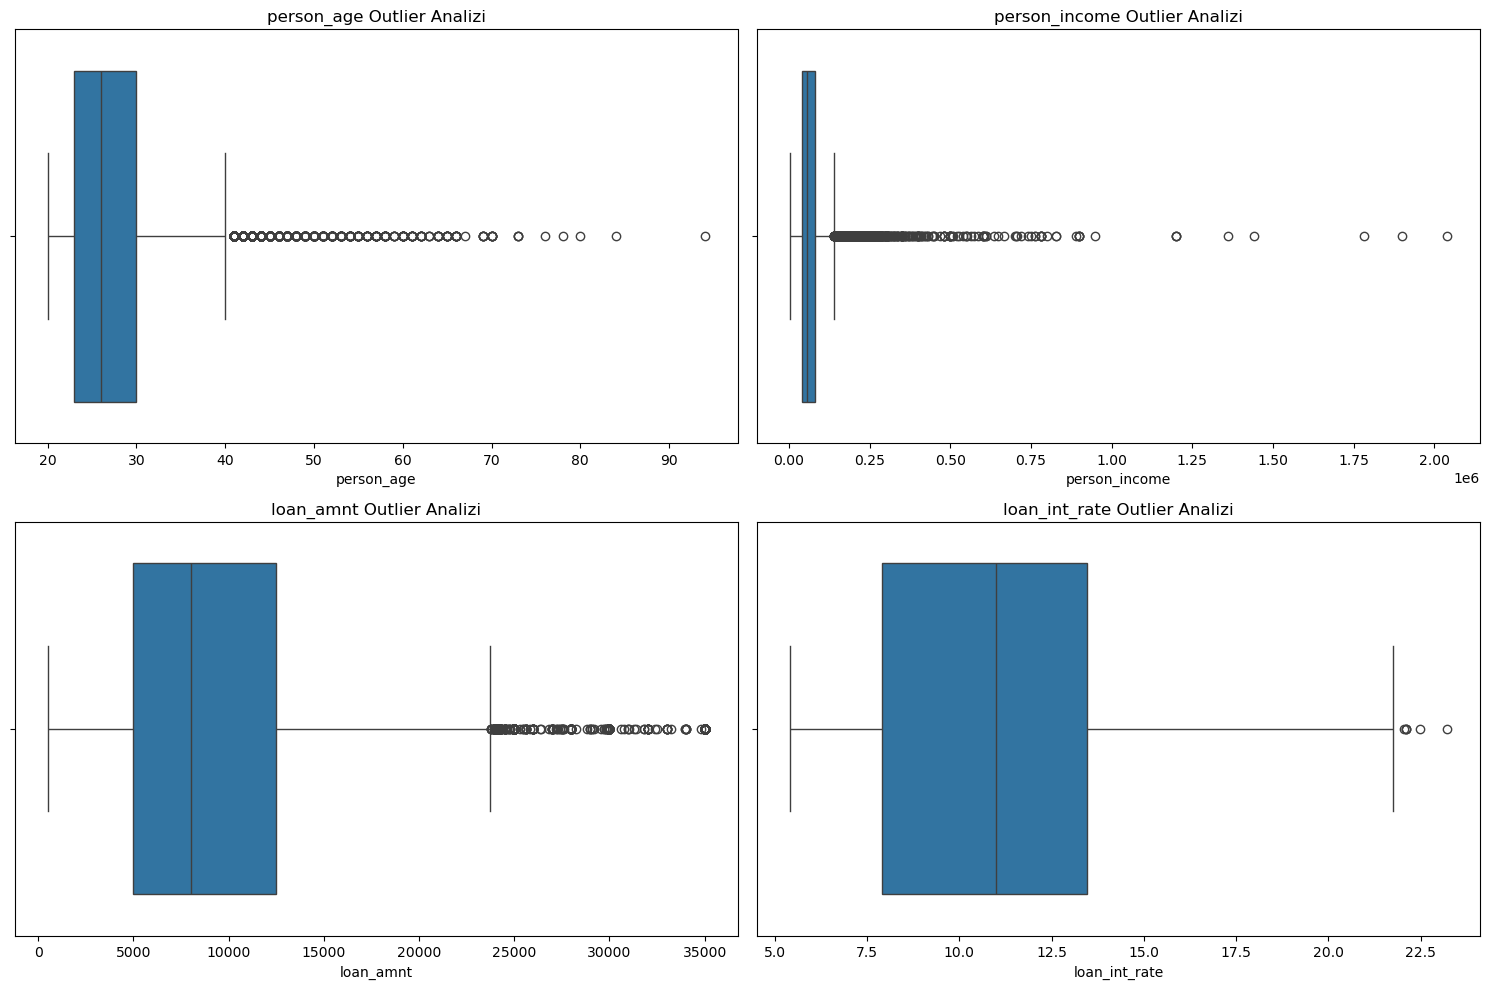

In [7]:
plt.figure(figsize=(15, 10))

# Gelir, Kredi Miktarı ve Yaş gibi sütunları görselleştirelim
cols_to_plot = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate']
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[col])
    plt.title(f'{col} Outlier Analizi')

plt.tight_layout()
plt.show()

In [8]:
# 1. Gelir temizliği (300k üstü %1'den bile azdır, atıyoruz)
onceki_sayi = len(df)
df = df[df['person_income'] <= 300000]
sonraki_sayi = len(df)

print(f"Gelir temizliği sonrası silinen kayıt: {onceki_sayi - sonraki_sayi}")

# 2. Mantıksız Kredi/Gelir Oranı kontrolü
# Gelirinin %70'inden fazlasını takside bağlayanları da (çok uç örnekler) temizleyebiliriz
df = df[df['loan_percent_income'] < 0.7]

# 3. Sonuçları görelim
print("\nTemizlenmiş Veri Seti Özeti:")
print(df[['person_income', 'person_age', 'loan_percent_income']].describe())

Gelir temizliği sonrası silinen kayıt: 135

Temizlenmiş Veri Seti Özeti:
       person_income    person_age  loan_percent_income
count   31532.000000  31532.000000         31532.000000
mean    64448.033807     27.695421             0.169958
std     37467.745908      6.181207             0.105567
min      4000.000000     20.000000             0.010000
25%     39000.000000     23.000000             0.090000
50%     55500.000000     26.000000             0.150000
75%     79992.000000     30.000000             0.230000
max    300000.000000     94.000000             0.690000


In [9]:
# Kategorik sütunlarda kaçar tane veri var?
for col in df.select_dtypes(include=['object']).columns:
    print(f"\n{col} dağılımı:")
    print(df[col].value_counts())


person_home_ownership dağılımı:
person_home_ownership
RENT        16037
MORTGAGE    12993
OWN          2397
OTHER         105
Name: count, dtype: int64

loan_intent dağılımı:
loan_intent
EDUCATION            6272
MEDICAL              5869
VENTURE              5531
PERSONAL             5335
DEBTCONSOLIDATION    5035
HOMEIMPROVEMENT      3490
Name: count, dtype: int64

loan_grade dağılımı:
loan_grade
A    10334
B    10133
C     6287
D     3535
E      946
F      233
G       64
Name: count, dtype: int64

cb_person_default_on_file dağılımı:
cb_person_default_on_file
N    25941
Y     5591
Name: count, dtype: int64


In [10]:
# Kredi geçmişi yaştan büyük olan var mı?
invalid_cred_hist = df[df['cb_person_cred_hist_length'] > (df['person_age'] - 14)]
print(f"Mantıksız kredi geçmişi kaydı sayısı: {len(invalid_cred_hist)}")

# Eğer varsa temizleyelim
df = df[df['cb_person_cred_hist_length'] <= (df['person_age'] - 14)]

Mantıksız kredi geçmişi kaydı sayısı: 0


In [11]:
import scipy.stats as stats

print(f"Gelir sütunu çarpıklık değeri: {df['person_income'].skew()}")
# Eğer bu değer 1'den büyükse ciddi bir sağa çarpıklık vardır.

Gelir sütunu çarpıklık değeri: 1.8867161324382282


In [12]:
# 1. Kredi geçmişi mantık hatasını düzelt
df = df[df['cb_person_cred_hist_length'] <= (df['person_age'] - 14)]

# 2. Çok düşük frekanslı sınıfları (G grade gibi) uçuralım mı?
# (Senin onayına göre burayı ekleyeceğiz)

# 3. Boş değerlerin tam dolduğundan emin ol (Son kez)
print("Son boş değer kontrolü:\n", df.isnull().sum())

# 4. İndeksleri sıfırla (Satır sildiğimiz için indeksler atlamalı kaldı)
df.reset_index(drop=True, inplace=True)

Son boş değer kontrolü:
 person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


In [13]:
import numpy as np

# Gelir verisine Log1p dönüşümü uygulayalım (log1p = log(x+1), sıfır hatasından korur)
df['person_income_log'] = np.log1p(df['person_income'])

# Yeni çarpıklık değerini kontrol et
print(f"Log dönüşümü sonrası gelir çarpıklığı: {df['person_income_log'].skew()}")

# Eski sütunu silebiliriz (İsteğe bağlı, kalsın dersen kalabilir ama modelde log olanı kullanacağız)

Log dönüşümü sonrası gelir çarpıklığı: -0.060087157461530684


In [14]:
# Kredi Notunu Sayısallaştır (A=1 ... G=7)
grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df['loan_grade_num'] = df['loan_grade'].map(grade_map)

# Geçmişte Temerrüt (Y=1, N=0)
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].map({'N': 0, 'Y': 1})

# Toplam Faiz Yükü: Sadece kredi miktarı yetmez, faizle çarpımı gerçek riski gösterir.
df['interest_burden'] = (df['loan_amnt'] * df['loan_int_rate']) / 100

# Tecrübe Başına Gelir: Kaç yıllık tecrübeyle bu geliri elde etmiş?
df['income_per_emp_year'] = df['person_income'] / (df['person_emp_length'] + 1)

# Yaş/Kredi Geçmişi Oranı: Finansal olgunluk göstergesi
df['age_to_cred_hist_ratio'] = df['person_age'] / (df['cb_person_cred_hist_length'] + 1)

In [15]:
# Metinleri sütunlara dağıtalım
df_final = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent'], drop_first=True)

# Orijinal metinleri ve artık ihtiyacımız olmayan eski person_income sütununu düşürelim
# (Log halini kullanacağımız için orijinal geliri siliyoruz)
df_final.drop(['loan_grade', 'person_income'], axis=1, inplace=True)

print("Final Dataset Sütun Sayısı:", df_final.shape[1])

Final Dataset Sütun Sayısı: 21


----------------------------------------
🎯 RİSKİ (loan_status) EN ÇOK TETİKLEYEN İLK 10 FAKTÖR
----------------------------------------
loan_status                    1.000000
loan_percent_income            0.379824
loan_grade_num                 0.377712
loan_int_rate                  0.338651
person_home_ownership_RENT     0.235436
interest_burden                0.222256
cb_person_default_on_file      0.181067
loan_amnt                      0.113697
loan_intent_MEDICAL            0.057440
loan_intent_HOMEIMPROVEMENT    0.034933
Name: loan_status, dtype: float64

----------------------------------------
📉 RİSKİ AZALTAN (NEGATİF) FAKTÖRLER
----------------------------------------
income_per_emp_year         -0.057392
loan_intent_VENTURE         -0.077065
person_emp_length           -0.085986
person_home_ownership_OWN   -0.102718
person_income_log           -0.279554
Name: loan_status, dtype: float64


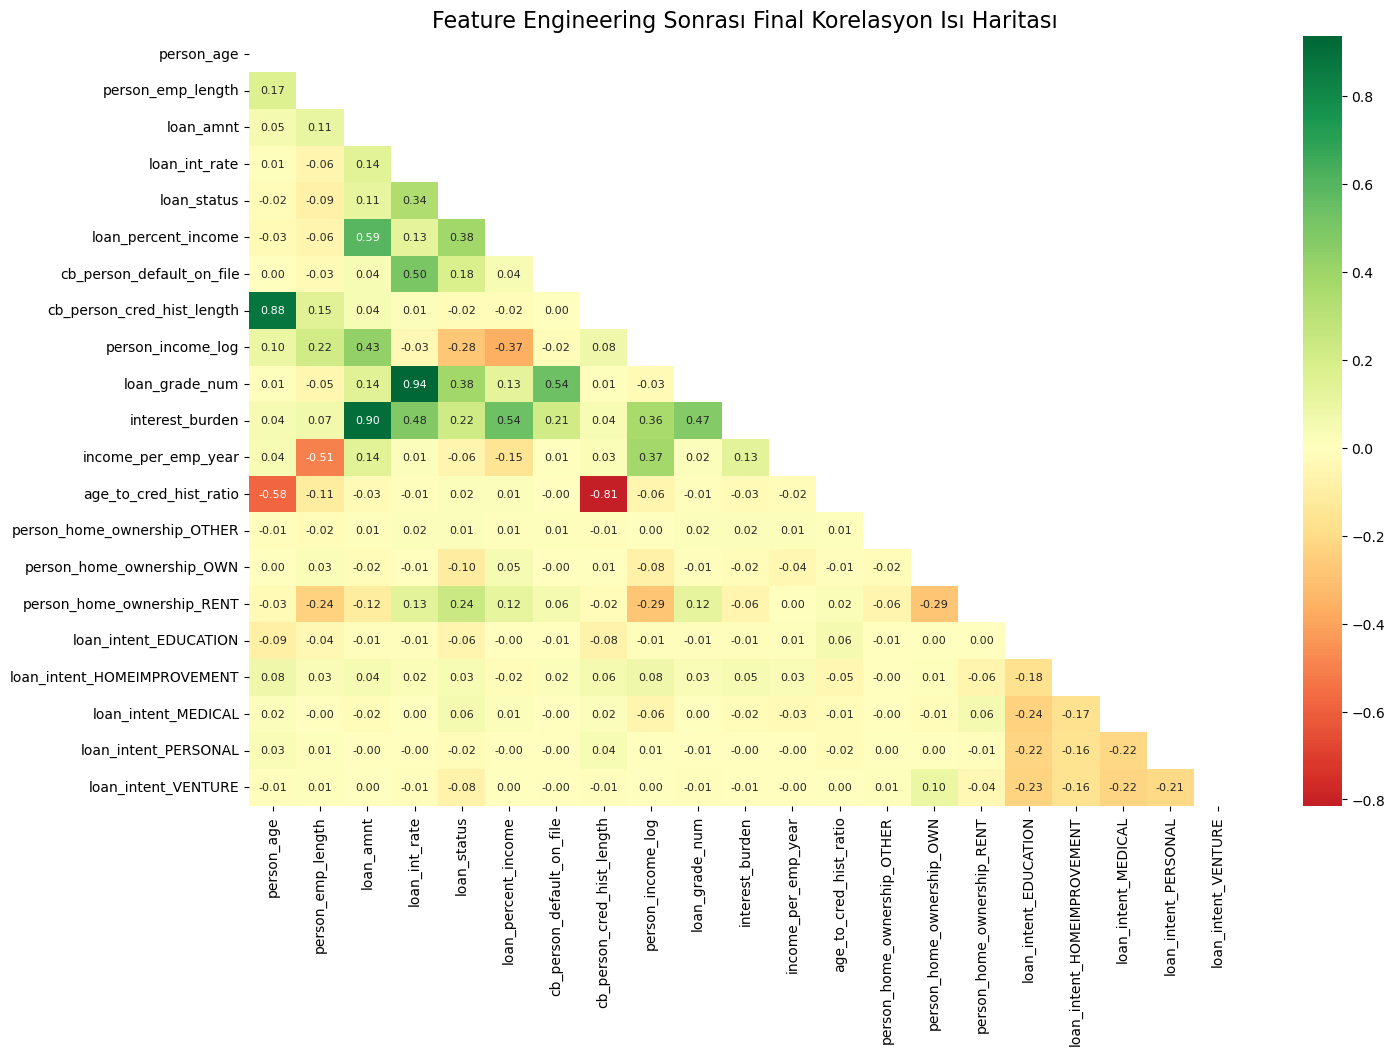

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Korelasyon Matrisini Hesapla
final_corr_matrix = df_final.corr()

# --- TERMINAL ÇIKTISI ---
print("-" * 40)
print("🎯 RİSKİ (loan_status) EN ÇOK TETİKLEYEN İLK 10 FAKTÖR")
print("-" * 40)
# loan_status ile olan korelasyonu mutlak değerce değil, yönüyle beraber sıralayalım
top_factors = final_corr_matrix['loan_status'].sort_values(ascending=False)
print(top_factors.head(10)) 
print("\n" + "-" * 40)
print("📉 RİSKİ AZALTAN (NEGATİF) FAKTÖRLER")
print("-" * 40)
print(top_factors.tail(5))

# --- GÖRSEL ÇIKTI (HEATMAP) ---
plt.figure(figsize=(16, 10))

# Daha temiz bir görüntü için sadece alt üçgeni gösterelim
mask = np.triu(np.ones_like(final_corr_matrix, dtype=bool))

sns.heatmap(final_corr_matrix, 
            mask=mask,
            annot=True, 
            fmt=".2f", 
            cmap='RdYlGn', # Kırmızı (Risk) - Yeşil (Güven) dengesi
            center=0,
            annot_kws={"size": 8}) # Yazı boyutunu biraz küçültelim ki sığsın

plt.title("Feature Engineering Sonrası Final Korelasyon Isı Haritası", fontsize=16)
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Özellikleri ve Hedefi Ayır
X = df_final.drop('loan_status', axis=1)
y = df_final['loan_status']

# 2. Veriyi Eğitim ve Test olarak böl (%80 Eğitim, %20 Test)
# random_state=42 veriyoruz ki her çalıştırdığımızda aynı bölünme olsun
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Eğitim Seti Boyutu: {X_train.shape}")
print(f"Test Seti Boyutu: {X_test.shape}")

# 3. Ölçeklendirme (StandardScaler)
scaler = StandardScaler()

# DİKKAT: Scaler sadece X_train üzerinde 'fit' edilir, sonra her ikisi 'transform' edilir.
# Neden? Çünkü test setini gelecekteki "bilinmeyen" veri gibi görmeliyiz.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nÖlçeklendirme tamamlandı. İlk satırın ilk 5 değeri:\n", X_train_scaled[0][:5])

Eğitim Seti Boyutu: (25225, 20)
Test Seti Boyutu: (6307, 20)

Ölçeklendirme tamamlandı. İlk satırın ilk 5 değeri:
 [-0.60108025  0.79928094 -0.41635887 -0.94154771 -0.85133693]


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Modeli Tanımla ve Eğit
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)

# 2. Tahmin Yap
y_pred = log_model.predict(X_test_scaled)

# 3. Sonuçları Değerlendir
print("--- LOJİSTİK REGRESYON SONUÇLARI ---")
print(f"Doğruluk (Accuracy) Skoru: {accuracy_score(y_test, y_pred):.4f}")
print("\nKarmaşıklık Matrisi (Confusion Matrix):")
print(confusion_matrix(y_test, y_pred))
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

--- LOJİSTİK REGRESYON SONUÇLARI ---
Doğruluk (Accuracy) Skoru: 0.8584

Karmaşıklık Matrisi (Confusion Matrix):
[[4679  267]
 [ 626  735]]

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4946
           1       0.73      0.54      0.62      1361

    accuracy                           0.86      6307
   macro avg       0.81      0.74      0.77      6307
weighted avg       0.85      0.86      0.85      6307



In [19]:
from sklearn.ensemble import RandomForestClassifier

# 1. Modeli Tanımla (Şimdilik temel parametrelerle)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Eğit
rf_model.fit(X_train_scaled, y_train)

# 3. Tahmin Yap
y_pred_rf = rf_model.predict(X_test_scaled)

# 4. Değerlendir
print("--- RANDOM FOREST SONUÇLARI ---")
print(f"Doğruluk (Accuracy) Skoru: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nKarmaşıklık Matrisi:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred_rf))

--- RANDOM FOREST SONUÇLARI ---
Doğruluk (Accuracy) Skoru: 0.9310

Karmaşıklık Matrisi:
[[4906   40]
 [ 395  966]]

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4946
           1       0.96      0.71      0.82      1361

    accuracy                           0.93      6307
   macro avg       0.94      0.85      0.89      6307
weighted avg       0.93      0.93      0.93      6307



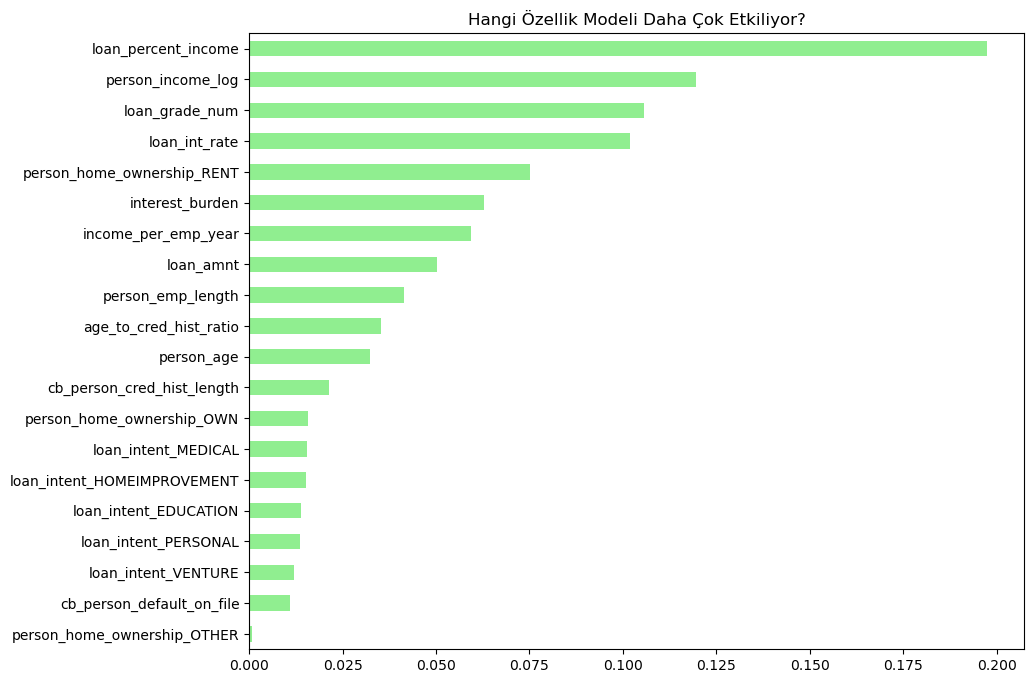

In [20]:
# Özellik önemlerini al ve sırala
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8), color='lightgreen')
plt.title("Hangi Özellik Modeli Daha Çok Etkiliyor?")
plt.show()

In [21]:
from sklearn.model_selection import GridSearchCV

# 1. Parametre Izgarasını Belirle
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', 'balanced_subsample']
}

# 2. GridSearchCV Objesini Oluştur
# scoring='f1' diyerek hem hassasiyeti hem duyarlılığı dengelemesini istiyoruz
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                           param_grid=param_grid, 
                           cv=3, n_jobs=-1, scoring='f1', verbose=2)

# 3. En İyi Kombinasyonu Ara
grid_search.fit(X_train_scaled, y_train)

# 4. En İyi Parametreleri Yazdır
print("En İyi Parametreler:", grid_search.best_params_)

# 5. En İyi Modeli Seç ve Tahmin Yap
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
En İyi Parametreler: {'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

# 1. En iyi modelle tahmin yap
y_pred_final = best_rf.predict(X_test_scaled)

# 2. Sonuçları yazdır
print("--- OPTİMİZE EDİLMİŞ RANDOM FOREST SONUÇLARI ---")
print(f"Final Doğruluk (Accuracy) Skoru: {accuracy_score(y_test, y_pred_final):.4f}")
print("\nFinal Karmaşıklık Matrisi:")
print(confusion_matrix(y_test, y_pred_final))
print("\nFinal Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred_final))

--- OPTİMİZE EDİLMİŞ RANDOM FOREST SONUÇLARI ---
Final Doğruluk (Accuracy) Skoru: 0.9288

Final Karmaşıklık Matrisi:
[[4893   53]
 [ 396  965]]

Final Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4946
           1       0.95      0.71      0.81      1361

    accuracy                           0.93      6307
   macro avg       0.94      0.85      0.88      6307
weighted avg       0.93      0.93      0.92      6307



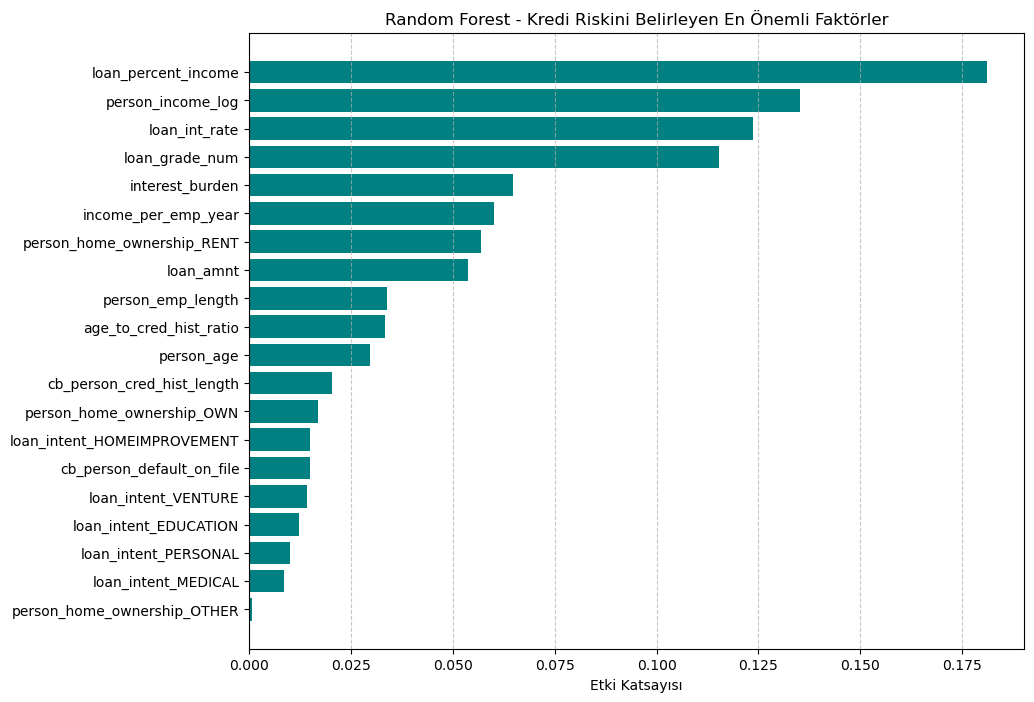

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# En iyi modelden özellik önemlerini al
importances = best_rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Özellik': feature_names, 'Önem': importances})
feature_importance_df = feature_importance_df.sort_values(by='Önem', ascending=True)

# Görselleştirme
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Özellik'], feature_importance_df['Önem'], color='teal')
plt.title('Random Forest - Kredi Riskini Belirleyen En Önemli Faktörler')
plt.xlabel('Etki Katsayısı')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [24]:
from xgboost import XGBClassifier

# 1. Sınıf ağırlığını hesapla (Dengesizliği gidermek için)
count_pos = (y_train == 1).sum()
count_neg = (y_train == 0).sum()
scale_weight = count_neg / count_pos

# 2. XGBoost Modelini Tanımla
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_weight, # Dengesiz veriyi dengele
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 3. Modeli Eğit
xgb_model.fit(X_train_scaled, y_train)

# 4. Tahmin Yap
y_pred_xgb = xgb_model.predict(X_test_scaled)

# 5. Sonuçları Değerlendir
print("--- XGBOOST SONUÇLARI ---")
print(f"Doğruluk (Accuracy) Skoru: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("\nKarmaşıklık Matrisi:")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred_xgb))

--- XGBOOST SONUÇLARI ---
Doğruluk (Accuracy) Skoru: 0.9199

Karmaşıklık Matrisi:
[[4741  205]
 [ 300 1061]]

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4946
           1       0.84      0.78      0.81      1361

    accuracy                           0.92      6307
   macro avg       0.89      0.87      0.88      6307
weighted avg       0.92      0.92      0.92      6307



C:\Users\yigit\.conda\envs\credit_risk_env\lib\site-packages\xgboost\training.py:199: UserWarning: [16:25:00] WARNING: C:\miniconda3\conda-bld\xgboost-split_1764761400759\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [25]:
import joblib

# Eğittiğimiz modeli ve yardımcıları paketliyoruz
joblib.dump(xgb_model, 'xgb_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(list(X.columns), 'model_columns.joblib')

print("✅ Model dosyaları klasöre başarıyla kaydedildi!")

✅ Model dosyaları klasöre başarıyla kaydedildi!
